<a href="https://colab.research.google.com/github/Prathyusha-Akundi/Skin-Classification/blob/main/multiscale_input_featurewiseNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Upwork/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download saumandas/isic-2019
! mkdir isic2019
! unzip isic-2019.zip -d isic2019

Streaming output truncated to the last 5000 lines.
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065357.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: isic2019/ISIC_2019_Trainin

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D 
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model


filterwarnings('ignore')
np.random.seed(101)
EFNS = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, 
        EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]

In [2]:
root_path = '/content/isic2019/'
IMAGE_DIR = ( '/content/isic2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input')
panda_path = os.path.join(root_path, 'ISIC_2019_Training_GroundTruth.csv')
print(len(os.listdir(IMAGE_DIR)))
#os.path.join

25333


In [3]:
def preprocess(df):
    for index, img in enumerate(df.image):
        img = img+'.jpg'
        df.image[index]=img
    df.drop(['UNK'], axis=1, inplace=True)

In [4]:
def train_val_test_split(df, test_len=1000, val_ratio=0.2):
    test_rows = (np.random.rand(1000)*df.shape[0]).astype(int)
    test_df =  df.iloc[test_rows]
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df.drop(test_rows, axis=0, inplace=True)
    df = df.reset_index().drop(['index'], axis=1)
    val_rows = (np.random.rand(int(val_ratio*df.shape[0]))*df.shape[0]).astype(int)
    val_df = df.iloc[val_rows]
    df.drop(val_rows, axis=0, inplace=True)
    val_df = val_df.reset_index().drop(['index'], axis=1)
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df = df.reset_index().drop(['index'], axis=1)
#     int_dict = {'MEL':int, 'NV':int, 'BCC':int, 'AK':int, 'BKL':int, 'DF':int, 'VASC':int, 'SCC':int}
#     df = df.astype(int_dict) 
#     val_df = val_df.astype(int_dict)
#     test_df = test_df.astype(int_dict)
    return df, val_df, test_df

In [5]:
full_df = pd.read_csv(panda_path)
preprocess(full_df)
train_df, val_df, test_df = train_val_test_split(full_df)
labels=list(train_df.columns[1:])
print(labels)
train_df.head()

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [7]:
labels = list(train_df.columns)[1:]

In [8]:
def get_segmentation_model(weights_path, inputs=None):
  # Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
  INPUT_CHANNELS = 3
  # Number of output masks (1 in case you predict only one type of objects)
  OUTPUT_MASK_CHANNELS = 1
  # Pretrained weights
  def double_conv_layer(x, size, dropout=0.40, batch_norm=True, name = None):
    
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same',name=name)(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

  dropout_val=0.50
    
  if inputs is None:  
    inputs = Input((256, 256, INPUT_CHANNELS))
  axis = 3
  filters = 32

  conv_256 = double_conv_layer(inputs, filters)
  pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_256)

  conv_112 = double_conv_layer(pool_112, 2*filters)
  pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

  conv_56 = double_conv_layer(pool_56, 4*filters)
  pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

  conv_28 = double_conv_layer(pool_28, 8*filters)
  pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

  conv_14 = double_conv_layer(pool_14, 16*filters)
  pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

  conv_7 = double_conv_layer(pool_7, 32*filters, name='features')

  up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
  up_conv_14 = double_conv_layer(up_14, 16*filters)

  up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
  up_conv_28 = double_conv_layer(up_28, 8*filters)

  up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
  up_conv_56 = double_conv_layer(up_56, 4*filters)

  up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
  up_conv_112 = double_conv_layer(up_112, 2*filters)

  up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_256], axis=axis)
  up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

  conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
  conv_final = Activation('sigmoid')(conv_final)
  pred = Reshape((256,256))(conv_final)
  model = Model(inputs, pred, name="UNET_256")
  model.load_weights(weights_path)
  return model

In [9]:
segmentation_weights = '/content/drive/MyDrive/Upwork/Skin Classification/segmentation_weights/segmentation_256_unet_final'
segmentator = get_segmentation_model(weights_path=segmentation_weights)
segmentator.trainable = False

In [10]:
def crop_mask_prep(im):
    im = np.reshape(im,(1,256,256,3))
    im = im*(1./255)
    mask = segmentator.predict(im)
    im = np.squeeze(im)
    mask = np.squeeze(mask)
    mask_ = np.dstack((mask,mask,mask))
    mask_ = np.uint8(mask_*255)
    try:
        maskgray = cv2.cvtColor(mask_,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(maskgray,127,255,cv2.THRESH_BINARY)
        # find contours 
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(contour) for contour in contours]
        cnt = contours[np.argmax(areas)]
        # straight rectangle
        x,y,w,h = cv2.boundingRect(cnt)
        final = im[y:y+h, x:x+w]
        final = cv2.resize(final, (256,256))
        final = np.uint8(final*255)
    except:
        final = np.uint8(im*255)

    
    return final

In [11]:
def get_generator(df=train_df, image_dir=IMAGE_DIR, x_col='image', y_cols=labels, shuffle=True, batch_size=32, seed=42, target_w = 256, target_h = 256):
    
    
    print("getting  generator...") 
    # normalize images
    image_generator1 = ImageDataGenerator(
        # rescale=1./255,  
        featurewise_center = True,
        featurewise_std_normalization = True,
#         preprocessing_function = preprocessing
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator1 = image_generator1.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    image_generator2 = ImageDataGenerator(
        # rescale=1./255,  
        featurewise_center = True,
        featurewise_std_normalization = True,
        preprocessing_function = crop_mask_prep
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator2= image_generator2.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    while True:
        X1i = generator1.next()
        X2i = generator2.next()
        yield [X1i[0], X2i[0]], X2i[1]

In [12]:
batch_size = 32
train_generator = get_generator(df = train_df, batch_size = batch_size)
valid_generator = get_generator(df = val_df, batch_size = batch_size)
test_generator = get_generator(df = test_df, batch_size = batch_size)

In [13]:
class_labels = train_df[labels].values
class_labels.shape

(19951, 8)

In [14]:
freq_pos, freq_neg = compute_class_freqs(class_labels)

pos_weights = freq_neg
neg_weights = freq_pos

In [15]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    
    return weighted_loss

In [16]:
x, y = next(train_generator)

getting  generator...
Found 19951 validated image filenames.
Found 19951 validated image filenames.


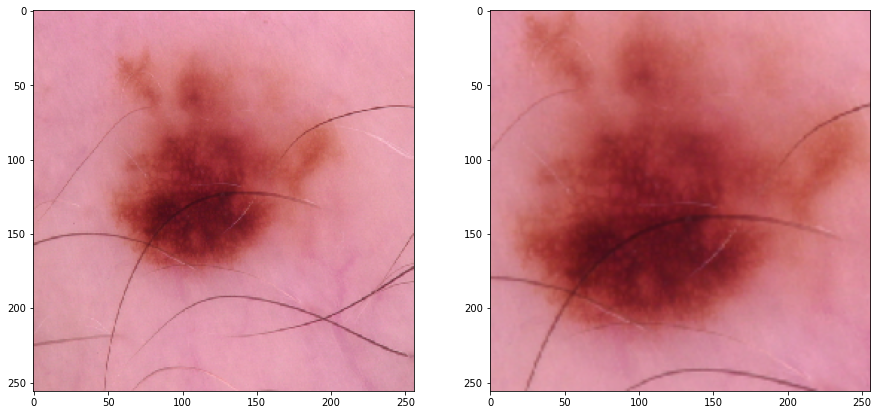

In [17]:
i = 8
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [18]:
(np.max(x[0][i]),np.max(x[1][i]))

(250.0, 241.0)

In [19]:
x, y = next(valid_generator)


getting  generator...
Found 4870 validated image filenames.
Found 4870 validated image filenames.


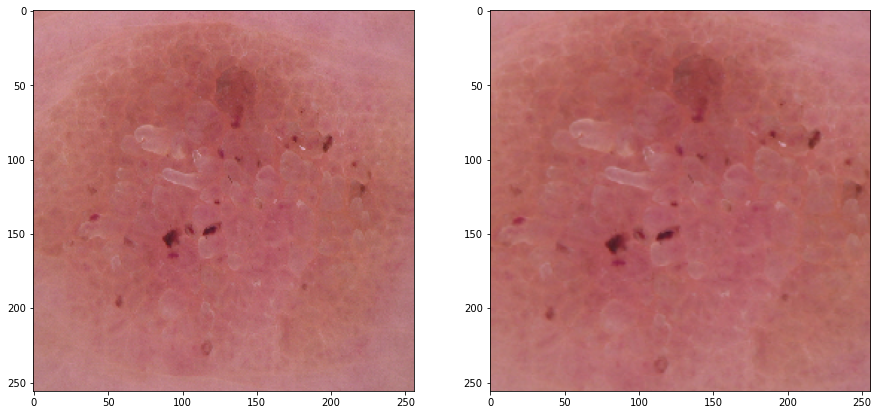

In [20]:
i = 9
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [21]:
(np.max(x[0][i]),np.max(x[1][i]))

(234.0, 211.0)

getting  generator...
Found 1000 validated image filenames.
Found 1000 validated image filenames.


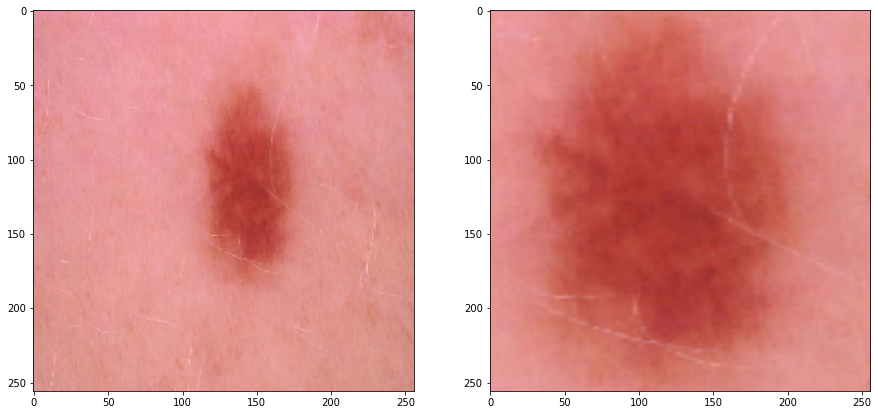

In [22]:
x, y = next(test_generator)

i = 10
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [23]:
(np.max(x[0][i]),np.max(x[1][i]))

(250.0, 246.0)

In [26]:
def get_classifier_model(labels,dim = 256, ef = 0):
    ### Base Model ###
    # Input
    
    input1 = Input(shape = (dim, dim, 3))
    input2 = Input(shape = (dim, dim, 3))
    # Base EfficientNet pretrained model
    base = EFNS[ef](
        input_shape = (dim, dim, 3),
        weights = "imagenet",
        include_top = False,
        # pooling = 'avg'
    )
    x1 = base(input1)    
    # x1 = Conv2D(512, (3, 3), padding='same',name='effnet_features1')(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    # x1 = tf.keras.layers.GlobalAveragePooling2D(name='effnet_features1')(x1)
    
    x2 = base(input2)
    # x2 = Conv2D(512, (3, 3), padding='same',name='effnet_features2')(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
    # x2 = tf.keras.layers.GlobalAveragePooling2D(name='effnet_features2')(x2)
    
    x = tf.keras.layers.Concatenate()([x1,x2])
    # x = ReLU()(x)
    # x = Dense(512, activation = "relu")(x)
    # x = Dropout(0.2)(x)

    # x = Dense(128, activation = "relu")(x)
   
    
    # x = base(inputs)
    # x = Conv2D(1024, (3, 3), padding='same',name='effnet_features')(x)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x1)

    ### Rebuild top ###
    x = Dense(labels, activation = "sigmoid")(x)


    model = Model(inputs = [input1, input2], outputs = x)
    model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])
   
    return model

In [27]:
model = get_classifier_model(len(labels))

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 8, 8, 1280)   4049571     ['input_5[0][0]',                
                                                                  'input_6[0][0]']            

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint_filepath = 'content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True)

In [30]:
STEP_SIZE_TRAIN=len(train_df)//batch_size
STEP_SIZE_VALID= len(val_df)//batch_size
STEP_SIZE_TEST=len(test_df)//batch_size
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,verbose=1,
                        validation_steps=STEP_SIZE_VALID, epochs=25, callbacks=[callback, model_checkpoint_callback])

Epoch 1/25
623/623 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.6109
Epoch 00001: val_loss improved from inf to 0.58144, saving model to content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0
623/623 [==============================] - 2400s 4s/step - loss: 0.5695 - accuracy: 0.6109 - val_loss: 0.5814 - val_accuracy: 0.6999
Epoch 2/25
623/623 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.7025
Epoch 00002: val_loss improved from 0.58144 to 0.51870, saving model to content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0
623/623 [==============================] - 2362s 4s/step - loss: 0.4490 - accuracy: 0.7025 - val_loss: 0.5187 - val_accuracy: 0.6999
Epoch 3/25
623/623 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.7518
Epoch 00003: val_loss did not improve from 0.51870
623/623 [==============================] - 2356s 4s/step - loss: 0.3766 - accuracy: 0.7518 - val_loss: 

In [31]:
model.load_weights(checkpoint_filepath)

In [32]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
import cv2

def get_roc_curve(labels, predicted_vals, ground_truth):
    auc_roc_vals = []
    predicted_vals = np.array(predicted_vals)
    ground_truth = np.array(ground_truth)
    for i in range(len(labels)):
#         try:
        gt = ground_truth[:, i]
        pred = predicted_vals[:, i]
        auc_roc = roc_auc_score(gt, pred)
        auc_roc_vals.append(auc_roc)
        fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
        plt.figure(1, figsize=(10, 10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf,
                 label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
#         except:
#             print(
#                 f"Error in generating ROC curve for {labels[i]}. "
#                 f"Dataset lacks enough examples."
#             )
    plt.show()
    return auc_roc_vals

def get_accuracy(ground_truth, predicted_vals):
    acc = np.zeros(len(labels))
    predicted_vals = np.array(predicted_vals)
    ground_truth = np.array(ground_truth)
    for i in range(len(labels)):
        pred = np.int32(predicted_vals[:,i]>0.5)
        gt = ground_truth[:, i]
        acc[i] = np.sum(pred==gt)/len(pred)
    return acc

In [33]:
from tqdm import tqdm
def get_predictions(generator, steps):
    preds = []
    gt = []
    cnt = 0
    for data, th in tqdm(generator):
        preds.extend(model.predict(data))
        gt.extend(th)
        cnt += 1
        if(cnt>= steps):
            break
    return preds, gt

In [34]:
predicted_vals2, gt_val = get_predictions(valid_generator, STEP_SIZE_VALID)

151it [07:39,  3.04s/it]


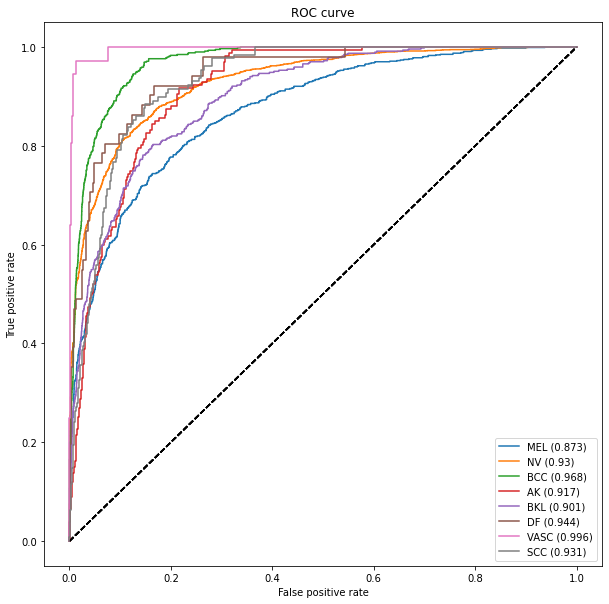

In [35]:
auc_rocs = get_roc_curve(labels, predicted_vals2, gt_val)

In [36]:
print([labels[i]+" : {0}".format(round(auc_rocs[i],3)) for i in range(len(labels))])
print('Mean AUC: {0}'.format(np.mean(auc_rocs)))

['MEL : 0.873', 'NV : 0.93', 'BCC : 0.968', 'AK : 0.917', 'BKL : 0.901', 'DF : 0.944', 'VASC : 0.996', 'SCC : 0.931']
Mean AUC: 0.932559911026499


In [37]:
val_acc = get_accuracy(gt_val, predicted_vals2)
print([labels[i]+" : {0}".format(round(val_acc[i],3)) for i in range(len(labels))])
print('Mean ACC: {0}'.format(np.mean(val_acc)))

['MEL : 0.824', 'NV : 0.851', 'BCC : 0.926', 'AK : 0.908', 'BKL : 0.749', 'DF : 0.801', 'VASC : 0.976', 'SCC : 0.871']
Mean ACC: 0.8631924348904506


In [38]:
predicted_test, gt_test = get_predictions(test_generator, STEP_SIZE_TEST)

30it [01:34,  3.16s/it]


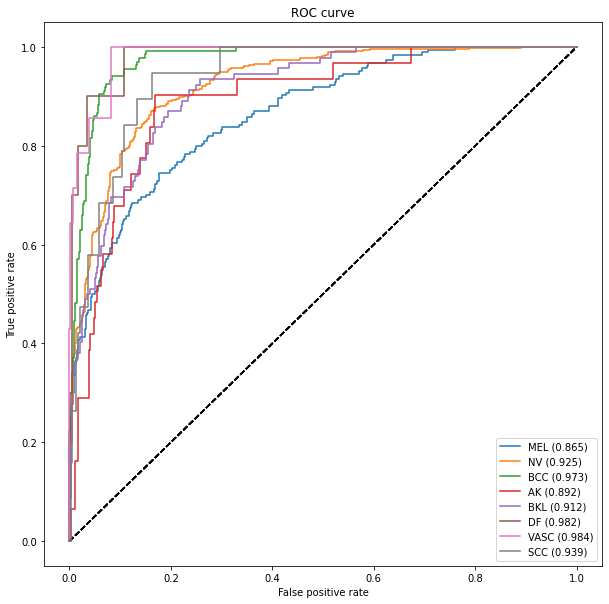

In [39]:
auc_rocs_test = get_roc_curve(labels, predicted_test, gt_test)

In [40]:
print([labels[i]+" : {0}".format(round(auc_rocs_test[i],3)) for i in range(len(labels))])
print('Mean AUC: {0}'.format(np.mean(auc_rocs_test)))

['MEL : 0.865', 'NV : 0.925', 'BCC : 0.973', 'AK : 0.892', 'BKL : 0.912', 'DF : 0.982', 'VASC : 0.984', 'SCC : 0.939']
Mean AUC: 0.9340467480066543


In [41]:
test_acc = get_accuracy(gt_test, predicted_test)

In [42]:
print([labels[i]+" : {0}".format(round(test_acc[i],3)) for i in range(len(labels))])
print('Mean ACC: {0}'.format(np.mean(test_acc)))

['MEL : 0.81', 'NV : 0.84', 'BCC : 0.934', 'AK : 0.902', 'BKL : 0.751', 'DF : 0.795', 'VASC : 0.982', 'SCC : 0.843']
Mean ACC: 0.8571797520661157
